<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im FS 2023.
</p>

## Ziel
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin <br>
beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach.  

Beispiel: Implementiere, trainiere und validiere ein Deep Learning Modell für Image <br>
Captioning wie beschrieben im Paper Show and Tell.

## Setup
Hier wird vor der Bearbeitung alles aufgesetzt.

In [1]:
# Install requirements
print("Installing requirements...")
%pip install --upgrade pip -q 
%pip install --upgrade -r requirements.txt -q
print("Done installing requirements!\n")

# Standard Libraries
import logging
import warnings

## Specific Imports
from PIL import Image

# 3rd Party Libraries
import torch
import torchvision
import pytorch_lightning as li
import numpy as np
import matplotlib as mpl
import nltk
import wandb

## Specific Imports
from matplotlib import pyplot as plt

# Internal Imports
from Manager import Manager
from Flickr8k import DataModuleFlickr8k

# Print information about the environment
print("Packages: ")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"  | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"  | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Set torch settings
if torch.cuda.is_available(): # explicitly use NVIDIA GPU's
    accelerator = "cuda"
else: # CPU, Apple M Series
    accelerator = "auto"
torch.set_float32_matmul_precision('medium')

# silent warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# download the nltk tokenizer
nltk.download("punkt", quiet=True)

# Final message
print("Setup complete!\n")

Installing requirements...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Done installing requirements!

Packages: 
 | PyTorch Version: 2.0.1
 | Torchvision Version: 0.15.2
 | PyTorch Lightning Version: 2.0.2
 | Numpy Version: 1.24.3
 | Matplotlib Version: 3.7.1
 | NLTK Version: 3.8.1
 | Wandb Version: 0.15.2

Backends: 
 | CUDA: False
  | CUDA Built: False
 | MPS: True
  | MPS Built: True

Ressources: 
 | CPU Threads: 8
env: WANDB_SILENT=True
Setup complete!



## Arbeitsschritte

### Schritt 1: Daten 
Gemäss Vereinbarung (für Captioning: Flickr8k-Daten). 

Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

In [2]:
dataModule = DataModuleFlickr8k(None)
dataModule = dataModule.prepare_data()

100%|██████████| 8091/8091 [00:36<00:00, 223.74it/s]


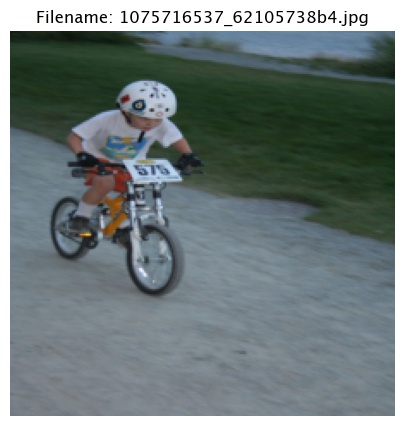

Captions:
 | ['a', 'child', 'with', 'a', 'helmet', 'on', 'his', 'head', 'rides', 'a', 'bike', '.']
 | ['a', 'little', 'boy', 'rides', 'a', 'bike', 'down', 'a', 'hill', 'on', 'a', 'miniature', 'dirt', 'bike', '.']
 | ['a', 'young', 'boy', 'in', 'a', 'helmet', 'rides', 'a', 'bike', 'on', 'the', 'road', '.']
 | ['the', 'little', 'boy', 'rides', 'his', 'bicycle', 'in', 'a', 'race', '.']
 | ['the', 'young', 'boy', 'pedals', 'quickly', 'at', 'a', 'bmx', 'race', '.']


In [3]:
# Show a random image and the first caption
filename, image, captions = dataModule.data[55]
plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Filename: {filename}")
plt.axis("off")
plt.show()

print("Captions:")
for caption in captions:
    print(f" | {caption}")

### Schritt 2: Aufbau Modellierung 
Überlege Dir, welche Modell-Architektur Sinn machen könnte. Das Paper von Vinyals <br>
(https://arxiv.org/pdf/1411.4555.pdf) war wichtig in diesem Zusammenhang. du kannst <br>
Dich auf Ihre Architektur beziehen oder auch eine eigene, evt. einfachere verwenden.  <br>
Zwei Modell-Varianten sollen aufgebaut werden: 
 
Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

### Schritt 3: Training und Evaluation 
Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust. 

### Schritt 4: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  